# Topic Modeling


Topic Modelling is one of the techniques used to conduct text analysis. As the name suggests, this method is used to find various topics that are present in the corpus. The idea is that each document in the corpus is made up of one or more than one topic and each topic is built from a bag of words. 

This notebook covers one of the most popular technique of Topic Modelling, **Latent Dirichlet Allocation**. This method was specifically designed for text data. 

As mentioned earlier, Topic Modelling is conducted on a bag of words and this is represented with a **document term matrix** of the entire corpus. 

In brief, LDA is using probability distribution for the each word and..............


## Library Imports

In [1]:
# Import Os to get to the root directory
import os
import sys

# Root directory of the project
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)

# Import own functions
from libraries import corpus
from libraries import pdf2text
import spacy
import en_core_web_sm
nlp = spacy.load('en_core_web_sm', disable =['parser', 'ner'])
import re, numpy as np, pandas as pd
from pprint import pprint

#gensim
import gensim
import gensim, spacy, logging, warnings
from gensim import corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

import matplotlib.pyplot as plt
%matplotlib inline

#nltk
import nltk as nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
from nltk.stem.wordnet import WordNetLemmatizer
import string

#other imports
import warnings
from importlib import reload
warnings.filterwarnings("ignore", category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

## Data Preprocessing

In [2]:
#import dataset
reload(corpus)

<module 'libraries.corpus' from 'C:\\Users\\user\\Documents\\GitHub\\datascience_project\\libraries\\corpus.py'>

In [3]:
dataset = pdf2text.get_dataset()

2019-06-11 23:17:34,713 [MainThread  ] [WARNI]  Failed to see startup log message; retrying...
2019-06-11 23:17:34,713 : WARNING : Failed to see startup log message; retrying...


In [4]:
dataset.keys()

dict_keys(['0chain', '1World', '1x2Coin', 'AB-CHAIN', 'ABCC', 'ABLE', 'Absolute', 'ACE', 'Achain', 'AcreCoin', 'Actinium', 'AcuteAngle', 'Adamant', 'AdBank', 'AdChainRegistry', 'AdCoin', 'Adhive', 'Aditus', 'Adshares', 'Alluva', 'Ample!', 'ArkIO', 'BasicAttentionToken', 'Binance', 'bitcoin', 'BitcoinGold', 'BitStash', 'Budbo', 'Bytecoin', 'Cosmos', 'CryptoNote', 'DaiStableCoinSystem', 'dash', 'Decentraland', 'Digix', 'Enjin', 'EtherAce', 'ethereum', 'EthereumClassic', 'Giant', 'GiveCoin', 'Golem', 'GuaranteedEntranceToken', 'GXChain', 'ICON', 'IOTA', 'KwattCoin', 'Latoken', 'MoneroV', 'Neox', 'oceanprotocol', 'opbusiness', 'opmarket', 'oxcert', 'RippleProtocol', 'SDUSD', 'SnipCoin', 'Solve', 'Steem', 'StellarConcensusProtocol', 'Tether', 'Tezos', 'Tron', 'Vechain', 'Zerocash'])

In [5]:
corpora = corpus.makeCleanCorpus(dataset, lemmatize=False, removePunct=True, removeNums=True,makeSentences=True, removeURL=True)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Cleaning: 0chain
Cleaning: 1World
Cleaning: 1x2Coin
Cleaning: AB-CHAIN
Cleaning: ABCC
Cleaning: ABLE
Cleaning: Absolute
Cleaning: ACE
Cleaning: Achain
Cleaning: AcreCoin
Cleaning: Actinium
Cleaning: AcuteAngle
Cleaning: Adamant
Cleaning: AdBank
Cleaning: AdChainRegistry
Cleaning: AdCoin
Cleaning: Adhive
Cleaning: Aditus
C

In [6]:
corpora['oceanprotocol'][:5]

['ocean protocol decentralized substrate ai data services technical whitepaper ocean protocol foundation bigchaindb gmbh newton circus dex pte',
 'ltd version apr abstract paper presents ocean protocol',
 'ocean decentralized protocol network artificial intelligence ai dataservices',
 'aims spread benefits ai unlocking data preserving privacy',
 'helps power marketplaces buysell ai data services software publish access commons data aidata science tools consume data']

In [7]:
#Our dictionary at the moment is in key: blockchain firms, value: list of text of whitepapers
#We change this to key: blockchain firms and value: string format
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

In [8]:
#Combining then
data_combined = {key:[combine_text(value)] for (key, value) in corpora.items()}

In [9]:
#Putting the text into pandas dataframe
import pandas as pd
pd.set_option('max_colwidth', 150)

data_df = pd.DataFrame.from_dict(data_combined).transpose()
data_df.columns = ['whitepapers']
data_df = data_df.sort_index()

In [10]:
#Glancing into Ocean Protocol Whitepaper
data_df.whitepapers.loc['oceanprotocol']

'ocean protocol decentralized substrate ai data services technical whitepaper ocean protocol foundation bigchaindb gmbh newton circus dex pte ltd version apr abstract paper presents ocean protocol ocean decentralized protocol network artificial intelligence ai dataservices aims spread benefits ai unlocking data preserving privacy helps power marketplaces buysell ai data services software publish access commons data aidata science tools consume data ocean decentralized orchestration core decentralized service agreements decentralized access control execute decentralized virtual machines allows connection monetization curation arbitrary data services ocean adds network rewards incentivize data sharing including privacypreserving data commons technical whitepaper intended accompany information memorandum token distribution details published ocean protocol foundation ltd information memorandum accordingly technical whitepaper intended read conjunction subject legal disclaimers notices set 

In [11]:
#Pickling the data for future use. 
import pickle
data_df.to_pickle('tmcorpus.pkl')

### Document-Term Matrix

Since the goal of this notebook is Topic Modelling, the text must be tokenized which means broken down to small pieces which here is words. We use scikit-learn's CountVectorizer technique where every row represents a different document and every column will represent a different word. 

At this moment, stop words are also removed thanks to CountVectorizer. Stop words are common words that seldom adds meaning or value to the text. 


In [12]:
#Creating a document-term matrix using CountVectorizer, and removing common english stop words. 

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words ='english')
data_cv = cv.fit_transform(data_df.whitepapers)
data_dtm = pd.DataFrame(data_cv.toarray(), columns = cv.get_feature_names())
data_dtm.index = data_df.index
data_dtm

,aa,aac,aacs,aand,aapl,aaron,ab,abadi,abandon,abandoned,...,zug,zulkamal,zurrer,zv,zverev,zvonareva,zvonarevas,zxc,zynga,zz
0chain,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1World,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1x2Coin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AB-CHAIN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ABCC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ABLE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACE,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,1,1,0,0,0
Absolute,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Achain,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AcreCoin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
#pickling the document-term matrix
data_dtm.to_pickle('dtm.pkl')

In [19]:
#importing necessary modules for LDA and gensim
from gensim import matutils, models
import scipy.sparse
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level = logging.INFO)

In [20]:
#importing the term-document matrix and converting it into document-term matrix with transpose

tdm = data_dtm.transpose()
tdm.head(5)

,0chain,1World,1x2Coin,AB-CHAIN,ABCC,ABLE,ACE,Absolute,Achain,AcreCoin,...,Tron,Vechain,Zerocash,bitcoin,dash,ethereum,oceanprotocol,opbusiness,opmarket,oxcert
aa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aac,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aacs,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aand,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aapl,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [21]:
#Converting the term-document matrix into gensim corpus format which follows a sequence from dataframe to sparse matrix to gensim corpus
sparse_docs = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_docs)

In [22]:
#Creating term dictionary of our corpus, where every unique term is assigned an index
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

In [ ]:
#lda time!!!
lda = models.LdaModel(corpus = corpus, id2word = id2word, num_topics = 10, passes= 30)
lda.print_topics()

## Visualization / Outcome

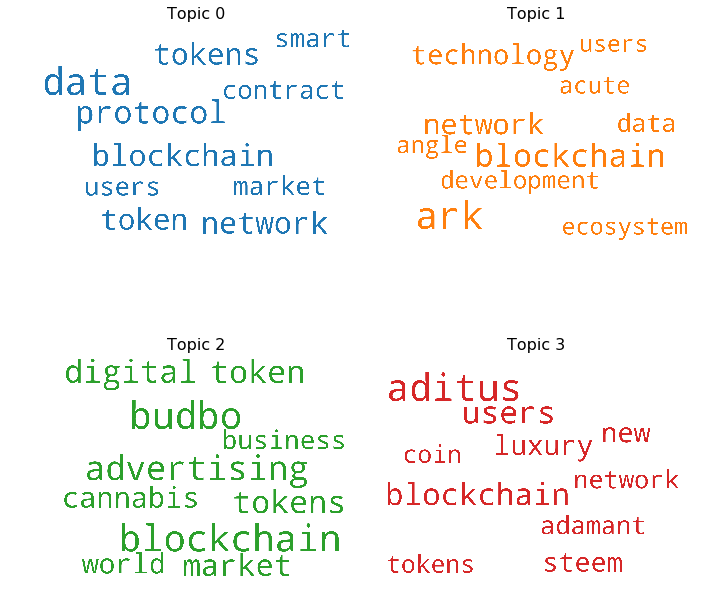

In [26]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

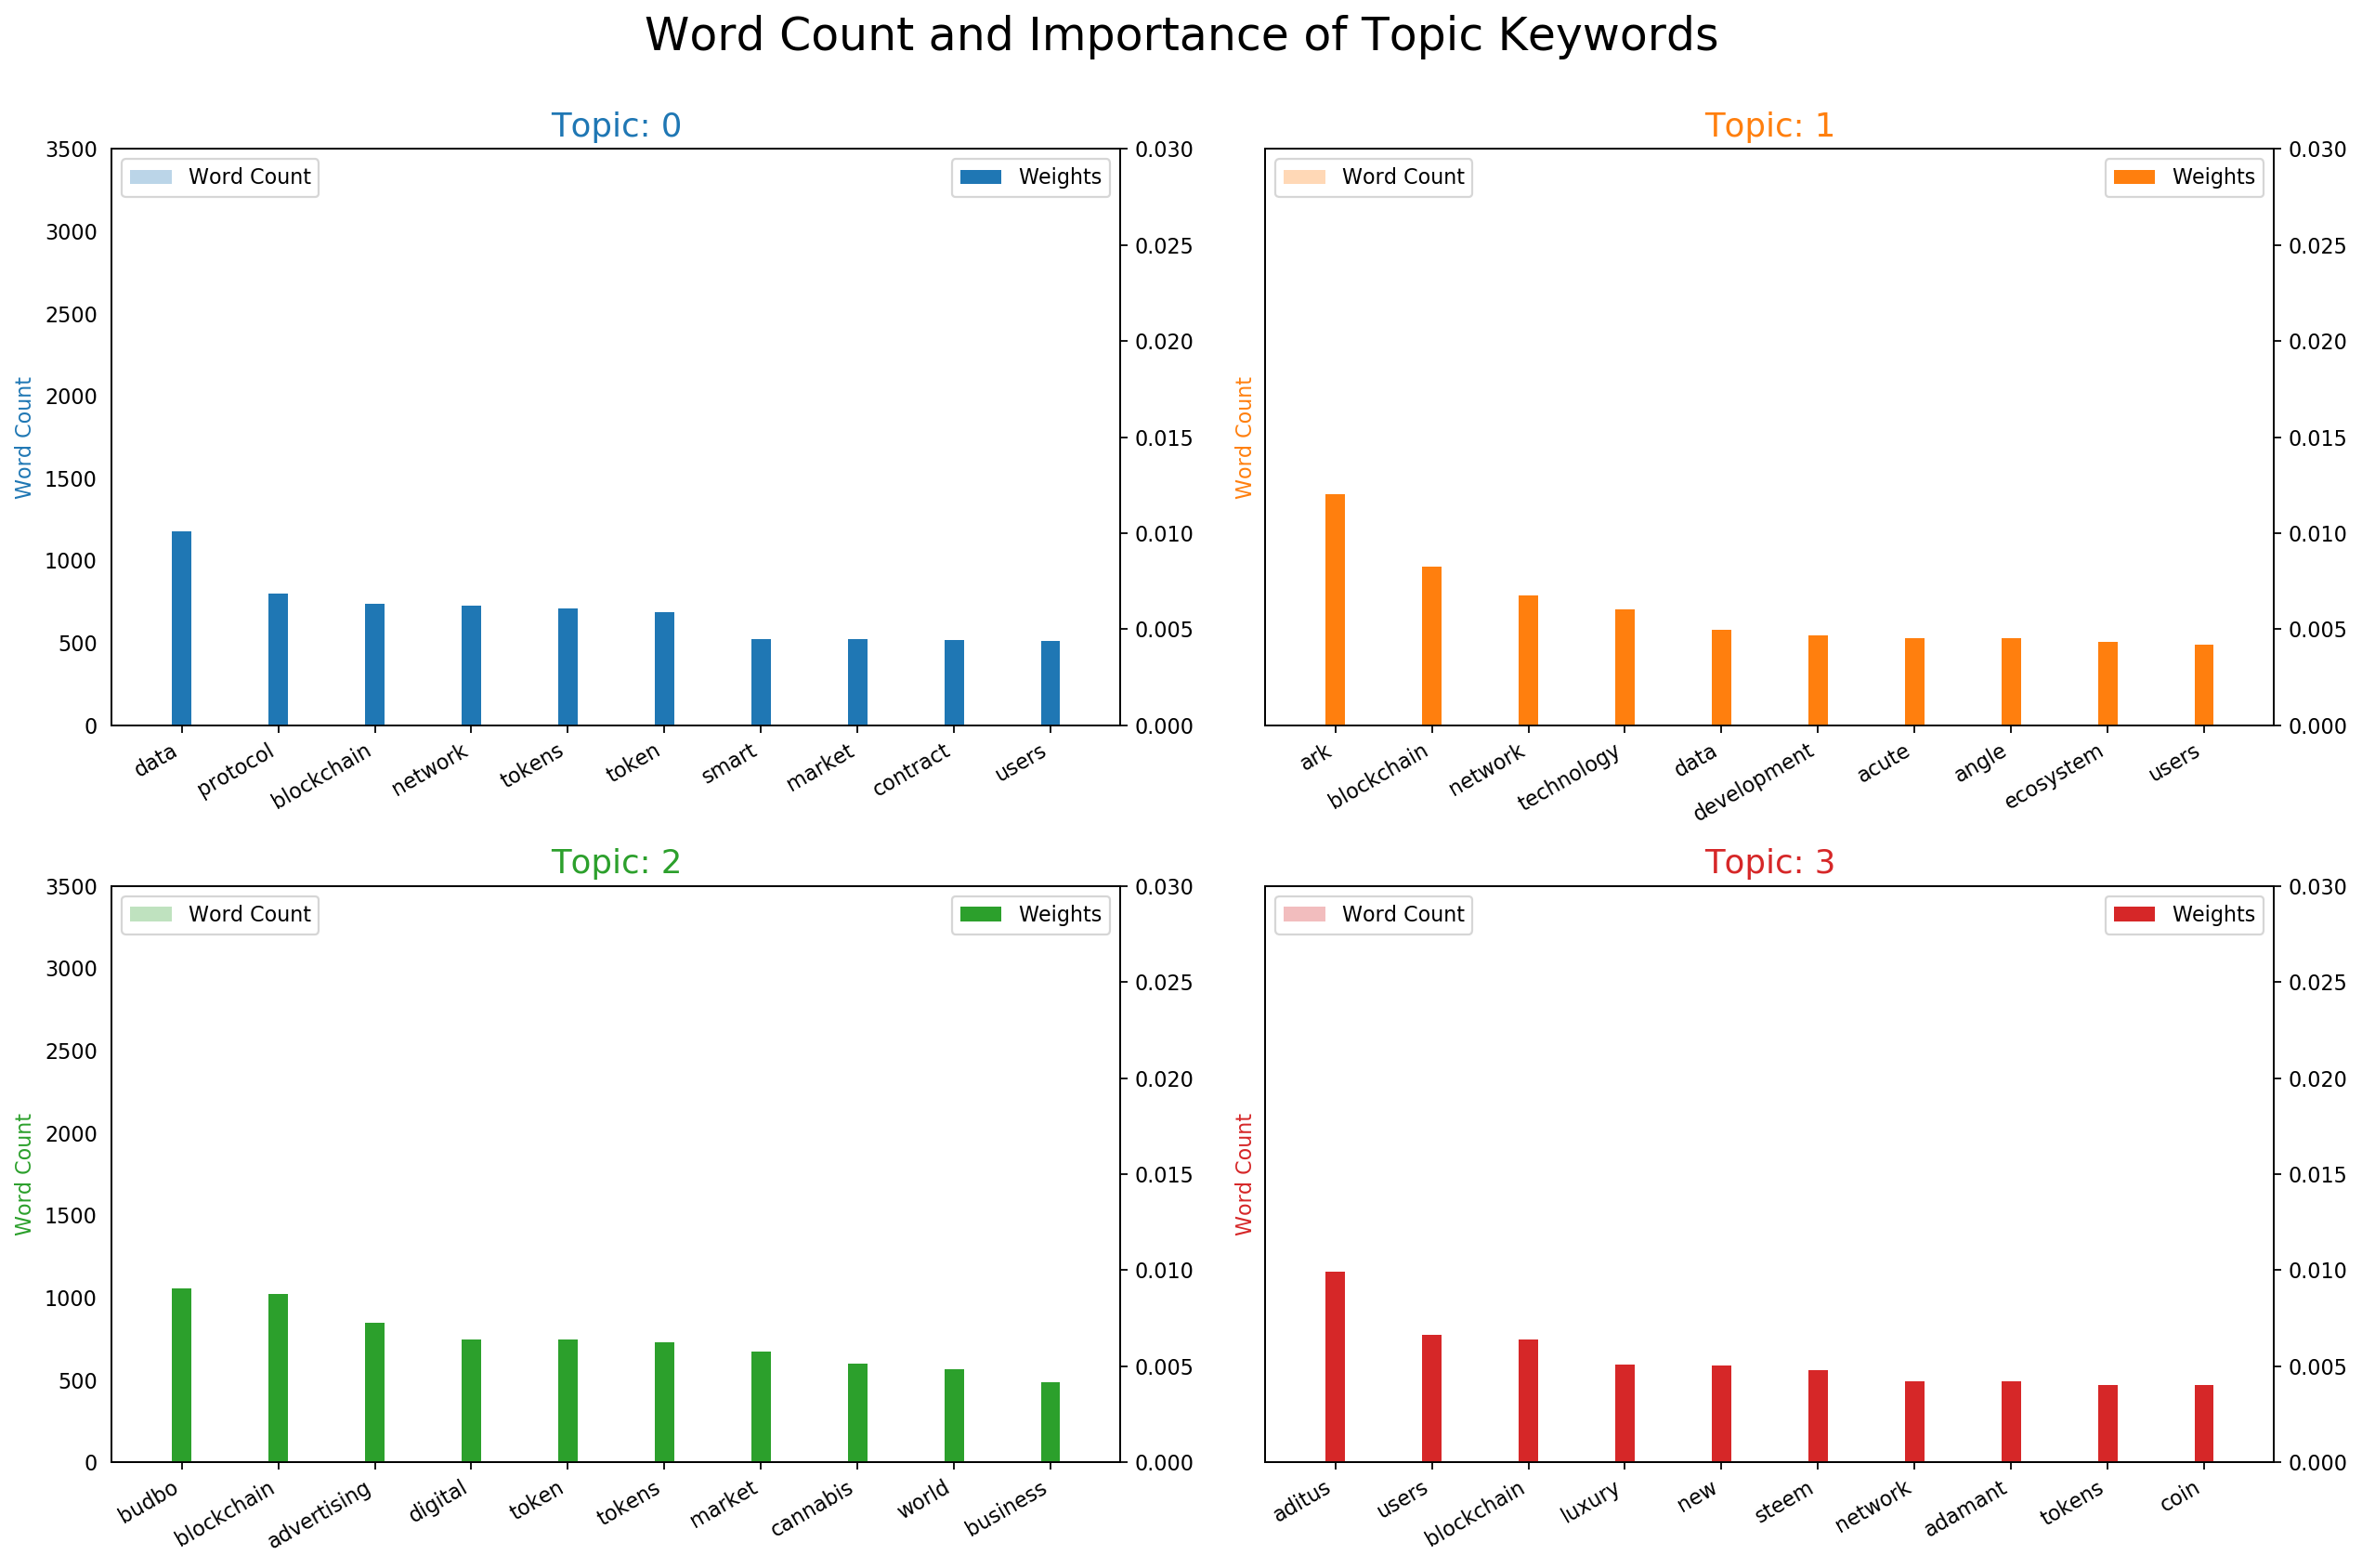

In [27]:
from collections import Counter
topics = lda.show_topics(formatted=False)
data_flat = [w for w_list in corpus for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## Method Application

References:

https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

TopicModels_LDA Notebook from Prof. Markus Loecher